In [1]:
# set to True if in colab
in_colab = True
floatType = 32
last_data_idx = -1

In [2]:
import tensorflow as tf
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
if floatType == 16:
    tf.keras.backend.set_floatx('float16')

Mounted at /content/drive


In [12]:
if in_colab:
    import sys
    data_dir = "/content/drive/MyDrive/data/"
    VOC2012_path = data_dir
    tracker_path = data_dir
    sys.path.append(tracker_path)
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
    checkpoint_filepath = data_dir + "weights_fcn4/"
else:
    data_dir = "../data/"
    VOC2012_path = data_dir + "VOCdevkit/"
    tracker_path = "../Tracking_SSD_ReID/"
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
    checkpoint_filepath = data_dir + "weights_fcn4/"

## Import model

In [4]:
from models.FCN4 import FCN4
model = FCN4(tracker_ssd_path = tracker_path, 
             ssd_weights_path = ssd_weights_path,
             floatType = floatType,
             n_classes=3)

(None, 300, 300, 3)


## Prepare VOC2012 segmentation data

  0%|          | 0/2912 [00:00<?, ?it/s]


Loading images and annotations...


100%|██████████| 2912/2912 [40:06<00:00,  1.21it/s]



Convert to tensor...


  0%|          | 1/1084 [00:00<01:49,  9.90it/s]


Done
Images shape: (1084, 300, 300, 3), annotations shape: (1084, 300, 300, 1)
Reshape gt from (width,height,1) to (width,height,n_classes)


100%|██████████| 1084/1084 [00:01<00:00, 601.81it/s]


Images shape: (1084, 300, 300, 3), annotations shape: (1084, 300, 300, 3)
Examples:


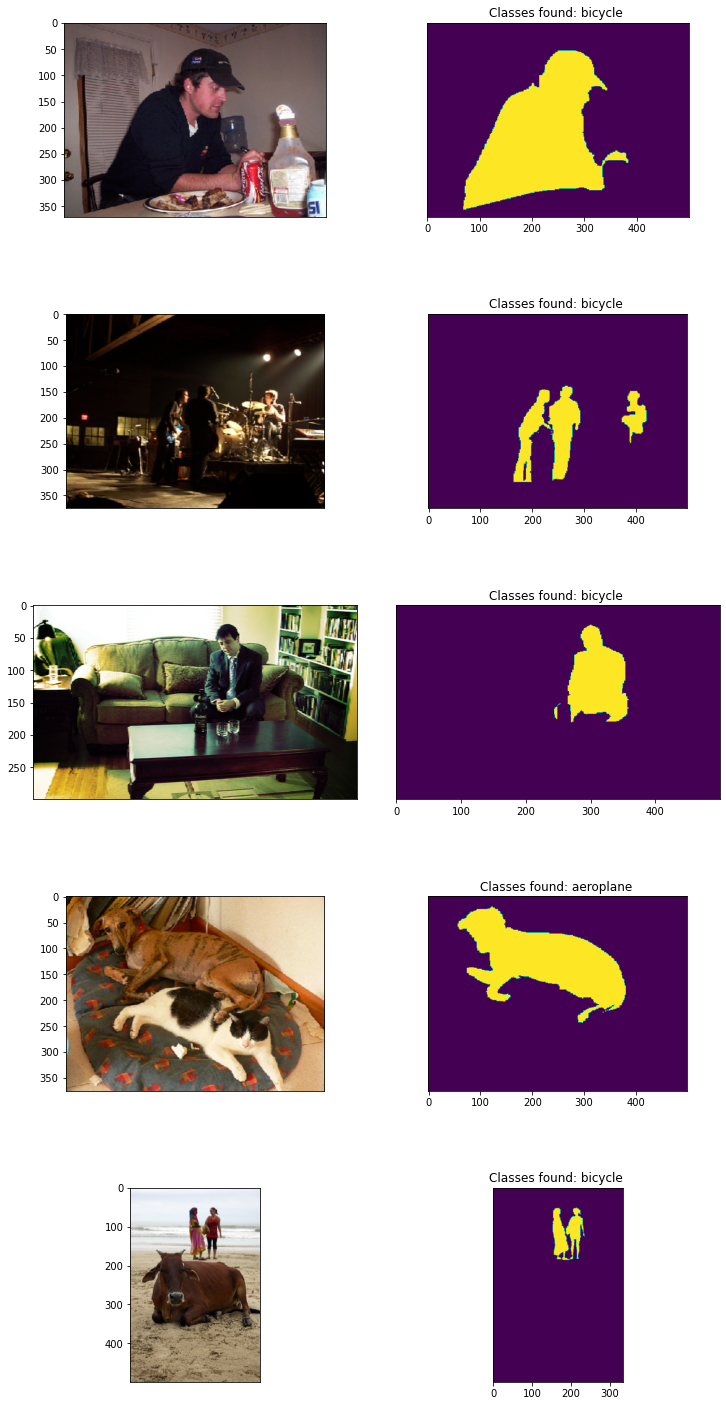

In [5]:
from data_management.VOC2012Manager import VOC2012Manager
input_shape=(300, 300, 3)

manager = VOC2012Manager(floatType = floatType, input_shape=input_shape)
targets = ["person", "dog"]
images, gt_annotations, filenames_png, original_shapes =\
    manager.load_and_prepare_data(
        VOC2012_path=VOC2012_path,
        n_samples_to_show=5,
        targets=targets,
        last_data_idx=last_data_idx)

In [6]:
train_ratio = 0.7
batch_size = 32
train_dataset, val_dataset = manager.tensorf2TFData(images, gt_annotations, train_ratio, batch_size)

In [7]:
# # verify train val shapes
# for train_img, train_annot in train_dataset:
#     break
# for val_img, val_annot in val_dataset:
#     break
# print(f"Train images shape: {train_img.shape}, train annotations shape: {train_annot.shape}")
# print(f"Val images shape: {val_img.shape}, Val annotations shape: {val_annot.shape}")

# del train_img, train_annot
# del val_img, val_annot

## Train model

In [13]:
sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [14]:
# number of training images
train_count = images.shape[0] * train_ratio

# number of validation images
validation_count = images.shape[0] * (1 - train_ratio)

epochs = 150

steps_per_epoch = train_count//batch_size
validation_steps = validation_count//batch_size

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [16]:
history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset, validation_steps=validation_steps,
                    epochs=epochs, callbacks=[model_checkpoint_callback])

Epoch 1/150
23/23 [==============================] - 13s 525ms/step - loss: 0.5519 - accuracy: 0.8191 - val_loss: 0.5374 - val_accuracy: 0.8198
Epoch 2/150
23/23 [==============================] - 13s 583ms/step - loss: 0.5074 - accuracy: 0.8223 - val_loss: 0.4876 - val_accuracy: 0.8345
Epoch 3/150
23/23 [==============================] - 13s 562ms/step - loss: 0.5016 - accuracy: 0.8202 - val_loss: 0.4537 - val_accuracy: 0.8196
Epoch 4/150
23/23 [==============================] - 12s 545ms/step - loss: 0.4389 - accuracy: 0.8272 - val_loss: 0.4152 - val_accuracy: 0.8367
Epoch 5/150
23/23 [==============================] - 12s 545ms/step - loss: 0.4247 - accuracy: 0.8365 - val_loss: 0.3950 - val_accuracy: 0.8492
Epoch 6/150
23/23 [==============================] - 12s 549ms/step - loss: 0.3734 - accuracy: 0.8529 - val_loss: 0.3409 - val_accuracy: 0.8640
Epoch 7/150
23/23 [==============================] - 12s 546ms/step - loss: 0.3620 - accuracy: 0.8534 - val_loss: 0.3645 - val_accuracy:

In [17]:
model.load_weights(checkpoint_filepath)

In [18]:
model.save(data_dir + "weights_fcn4_final/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/weights_fcn4_final/assets
